In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# 1) Load data 

In [3]:
# Change this if needed: should point to repo root
REPO_ROOT = os.getcwd()  # if notebook launched from repo root
# If notebook is inside /notebooks, uncomment:
# REPO_ROOT = os.path.abspath("..")
from pathlib import Path

REPO_ROOT = Path.cwd().parents[0]  # go from notebooks/ → project root
DATA_DIR = REPO_ROOT / "data"
cust_path   = os.path.join(REPO_ROOT, "data", "interim", "master_customers.csv")
tx_path     = os.path.join(REPO_ROOT, "data", "interim", "master_transactions.csv")
labels_path = os.path.join(REPO_ROOT, "data", "raw", "labels.csv")

cust = pd.read_csv(cust_path)
tx   = pd.read_csv(tx_path)
labels = pd.read_csv(labels_path)

tx["transaction_datetime"] = pd.to_datetime(tx["transaction_datetime"], errors="coerce")

print(cust.shape, tx.shape, labels.shape)
print(tx.columns.tolist())


C:\Users\shany\AppData\Local\Temp\ipykernel_20680\1450986940.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tx   = pd.read_csv(tx_path)


(61410, 15) (5903333, 15) (1000, 2)
['transaction_id', 'customer_id', 'amount_cad', 'debit_credit', 'transaction_datetime', 'cash_indicator', 'country', 'province', 'city', 'channel', 'merchant_category', 'ecommerce_ind', 'is_debit', 'is_credit', '_source_table']


# 2) Feature prototyping for 2 AML rules (features2_customers)
## A) TX-CASH-13 — night_cash_activity (30d ratio)

Definition (per customer):

window = last 30 days relative to their last transaction

night hours = 22:00–06:00

compute ratios/counts on cash transactions

In [4]:
def add_night_cash_features(tx: pd.DataFrame) -> pd.DataFrame:
    t = tx.dropna(subset=["transaction_datetime"]).copy()
    t["date"] = t["transaction_datetime"]
    
    # per-customer reference end date
    end_dt = t.groupby("customer_id")["date"].max().rename("end_dt")
    t = t.merge(end_dt, on="customer_id", how="left")
    t["days_from_end"] = (t["end_dt"] - t["date"]).dt.total_seconds() / (3600*24)

    # last 30 days window
    t30 = t[(t["days_from_end"] >= 0) & (t["days_from_end"] <= 30)].copy()

    # night indicator: hour in [22,23] OR [0..5]
    hour = t30["date"].dt.hour
    t30["is_night"] = (hour >= 22) | (hour < 6)

    # cash transaction indicator
    t30["is_cash"] = t30["cash_indicator"].fillna(0).astype(int).eq(1)

    # aggregates
    g = t30.groupby("customer_id")

    out = pd.DataFrame({
        "customer_id": g.size().index,
        "cash_txn_count_30d": g["is_cash"].sum(),
        "night_txn_count_30d": g["is_night"].sum(),
        "night_cash_txn_count_30d": (g.apply(lambda df: (df["is_cash"] & df["is_night"]).sum())),
        "cash_amt_sum_30d": g.apply(lambda df: df.loc[df["is_cash"], "amount_cad"].sum()),
        "night_cash_amt_sum_30d": g.apply(lambda df: df.loc[df["is_cash"] & df["is_night"], "amount_cad"].sum()),
    }).reset_index(drop=True)

    # ratios (safe divide)
    out["night_cash_ratio_30d"] = out["night_cash_txn_count_30d"] / out["cash_txn_count_30d"].replace(0, np.nan)
    out["night_cash_ratio_30d"] = out["night_cash_ratio_30d"].fillna(0.0)

    out["night_cash_amt_ratio_30d"] = out["night_cash_amt_sum_30d"] / out["cash_amt_sum_30d"].replace(0, np.nan)
    out["night_cash_amt_ratio_30d"] = out["night_cash_amt_ratio_30d"].fillna(0.0)

    return out

feat_night = add_night_cash_features(tx)
feat_night.head()


C:\Users\shany\AppData\Local\Temp\ipykernel_20680\2680470295.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "night_cash_txn_count_30d": (g.apply(lambda df: (df["is_cash"] & df["is_night"]).sum())),
C:\Users\shany\AppData\Local\Temp\ipykernel_20680\2680470295.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  "cash_amt_sum_30d": g.apply(lambda df: df.loc[df["is_cash"], "amount_cad"].sum()),
C:\Users\shany\AppD

,customer_id,cash_txn_count_30d,night_txn_count_30d,night_cash_txn_count_30d,cash_amt_sum_30d,night_cash_amt_sum_30d,night_cash_ratio_30d,night_cash_amt_ratio_30d
0,SYNID0100000167,0,0,0,0.00,0.00,0.000000,0.000000
1,SYNID0100000431,3,7,1,842.88,642.88,0.333333,0.762718
2,SYNID0100000485,1,1,0,415.92,0.00,0.000000,0.000000
3,SYNID0100000539,0,6,0,0.00,0.00,0.000000,0.000000
4,SYNID0100000932,1,9,0,1083.49,0.00,0.000000,0.000000


## B) TX-CASH-11 — cash_to_wire_pass_through (3d proxy)

We don’t have explicit “deposit vs withdrawal”, so we use a reasonable proxy:

cash “in” ≈ cash_indicator==1 AND is_credit==True

wire “out” ≈ channel=="wire" AND is_debit==True
Then per customer compute:

total cash_in amount (last 30d)

total wire_out amount within 3 days after cash_in events (approx via join)

ratio = wire_out_3d / cash_in

In [5]:
def add_cash_to_wire_passthrough(tx: pd.DataFrame) -> pd.DataFrame:
    t = tx.dropna(subset=["transaction_datetime"]).copy()
    t["dt"] = t["transaction_datetime"]
    
    # ensure flags exist
    if "is_credit" not in t.columns:
        t["is_credit"] = t["debit_credit"].astype(str).str.upper().eq("C")
    if "is_debit" not in t.columns:
        t["is_debit"] = t["debit_credit"].astype(str).str.upper().eq("D")

    # per-customer end date for windowing
    end_dt = t.groupby("customer_id")["dt"].max().rename("end_dt")
    t = t.merge(end_dt, on="customer_id", how="left")
    t["days_from_end"] = (t["end_dt"] - t["dt"]).dt.total_seconds() / (3600*24)
    t30 = t[(t["days_from_end"] >= 0) & (t["days_from_end"] <= 30)].copy()

    cash_in = t30[(t30["cash_indicator"].fillna(0).astype(int) == 1) & (t30["is_credit"] == True)].copy()
    wire_out = t30[(t30["channel"].astype(str).str.lower() == "wire") & (t30["is_debit"] == True)].copy()

    # If dataset has almost no C/D meaning, this feature may be weak — still ok for prototype.
    cash_in = cash_in[["customer_id", "dt", "amount_cad"]].rename(columns={"dt":"cash_dt", "amount_cad":"cash_amt"})
    wire_out = wire_out[["customer_id", "dt", "amount_cad"]].rename(columns={"dt":"wire_dt", "amount_cad":"wire_amt"})

    # join on customer, then keep wire within [cash_dt, cash_dt+3d]
    merged = cash_in.merge(wire_out, on="customer_id", how="left")
    within = merged[(merged["wire_dt"] >= merged["cash_dt"]) &
                    (merged["wire_dt"] <= merged["cash_dt"] + pd.Timedelta(days=3))]

    # aggregate per customer
    cash_sum = cash_in.groupby("customer_id")["cash_amt"].sum().rename("cash_in_amt_30d")
    wire_sum_3d = within.groupby("customer_id")["wire_amt"].sum().rename("wire_out_amt_within_3d_30d")

    out = pd.concat([cash_sum, wire_sum_3d], axis=1).fillna(0).reset_index()
    out["cash_to_wire_ratio_3d_30d"] = out["wire_out_amt_within_3d_30d"] / out["cash_in_amt_30d"].replace(0, np.nan)
    out["cash_to_wire_ratio_3d_30d"] = out["cash_to_wire_ratio_3d_30d"].fillna(0.0)

    return out

feat_passthrough = add_cash_to_wire_passthrough(tx)
feat_passthrough.head()


,customer_id,cash_in_amt_30d,wire_out_amt_within_3d_30d,cash_to_wire_ratio_3d_30d
0,SYNID0100000485,415.92,0.0,0.0
1,SYNID0100009578,300.57,0.0,0.0
2,SYNID0100015109,208.69,0.0,0.0
3,SYNID0100018428,214.06,0.0,0.0
4,SYNID0100018441,100.00,0.0,0.0


Save features2_customers.csv

In [6]:
features2 = feat_night.merge(feat_passthrough, on="customer_id", how="outer").fillna(0)
out_path = os.path.join(REPO_ROOT, "data", "processed", "features2_customers.csv")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
features2.to_csv(out_path, index=False)
out_path, features2.shape


('c:\\Users\\shany\\Documents\\GitHub\\aml-project\\data\\processed\\features2_customers.csv',
 (60213, 11))

# 3) Build modeling table + split labeled vs unlabeled

In [8]:
# Load your existing features_customers.csv if you already have it
feat1_path = os.path.join(REPO_ROOT, "data", "processed", "features_customer.csv")
feat1 = pd.read_csv(feat1_path)

# Merge everything
Xall = cust.merge(feat1, on="customer_id", how="left") \
           .merge(features2, on="customer_id", how="left")

# Attach labels (assume labels has columns: customer_id, label OR suspicious)
# adjust label column name if needed
label_col = "label" if "label" in labels.columns else labels.columns[-1]
df = Xall.merge(labels[["customer_id", label_col]], on="customer_id", how="left").rename(columns={label_col:"y"})

labeled = df[df["y"].notna()].copy()
unlabeled = df[df["y"].isna()].copy()

labeled["y"] = labeled["y"].astype(int)

print("labeled:", labeled.shape, "unlabeled:", unlabeled.shape)
print(labeled["y"].value_counts())


C:\Users\shany\AppData\Local\Temp\ipykernel_20680\1576323648.py:3: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  feat1 = pd.read_csv(feat1_path)


labeled: (1000, 67) unlabeled: (60410, 67)
y
0    990
1     10
Name: count, dtype: int64


# 4) Visualize if the features “move” with labels

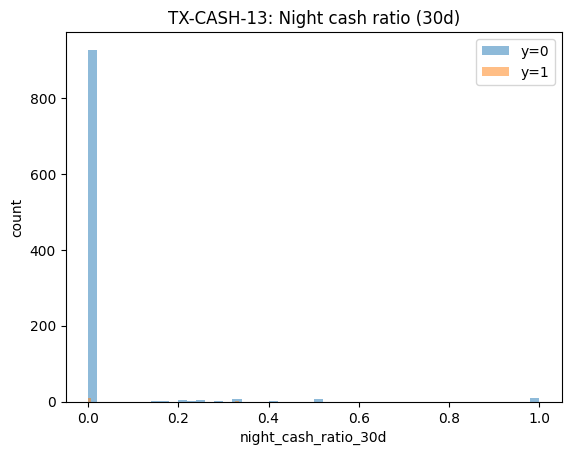

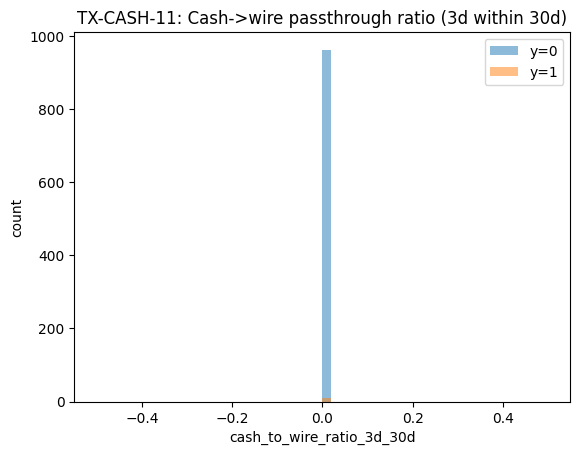

In [9]:
def plot_feature_by_label(df_labeled, col, title=None):
    g0 = df_labeled[df_labeled["y"] == 0][col].dropna()
    g1 = df_labeled[df_labeled["y"] == 1][col].dropna()

    plt.figure()
    plt.hist(g0, bins=50, alpha=0.5, label="y=0")
    plt.hist(g1, bins=50, alpha=0.5, label="y=1")
    plt.legend()
    plt.title(title or col)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

plot_feature_by_label(labeled, "night_cash_ratio_30d", "TX-CASH-13: Night cash ratio (30d)")
plot_feature_by_label(labeled, "cash_to_wire_ratio_3d_30d", "TX-CASH-11: Cash->wire passthrough ratio (3d within 30d)")


# 5) Train baseline supervised model (LogReg + RF)
Which models make sense here?

Logistic Regression: fast baseline, good for sanity, handles imbalance with class_weight="balanced"

RandomForest: handles non-linearities, robust baseline

KNN is usually not great for tabular AML (scaling + curse of dimensionality), but you can try later.

LogReg  AP(PR-AUC): 0.03185185185185185
LogReg  ROC-AUC: 0.8004032258064515


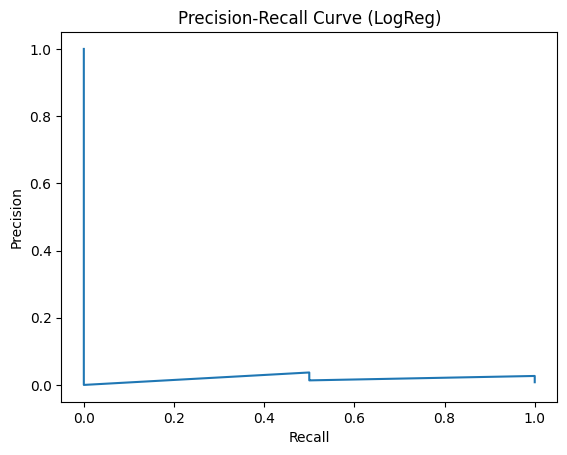

In [10]:
# Choose feature columns (start with just your rule-based ones + a few aggregates)
feature_cols = [
    "night_cash_ratio_30d",
    "night_cash_amt_ratio_30d",
    "cash_to_wire_ratio_3d_30d",
    "cash_txn_count_30d",
    "cash_in_amt_30d",
    "wire_out_amt_within_3d_30d",
    # from your features_customers.csv (already exists)
    "txn_count_all",
    "amt_sum_all",
    "cash_txn_ratio",
    "n_countries",
    "n_cities",
]

# Keep only columns that actually exist
feature_cols = [c for c in feature_cols if c in labeled.columns]

X = labeled[feature_cols].copy()
y = labeled["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Pipeline: impute -> scale -> model
lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=500, class_weight="balanced"))
])

lr.fit(X_train, y_train)
proba = lr.predict_proba(X_test)[:, 1]

ap = average_precision_score(y_test, proba)
roc = roc_auc_score(y_test, proba)

print("LogReg  AP(PR-AUC):", ap)
print("LogReg  ROC-AUC:", roc)

prec, rec, thr = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LogReg)")
plt.show()


RandomForest baseline:

In [11]:
rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
proba_rf = rf.predict_proba(X_test)[:, 1]

print("RF AP(PR-AUC):", average_precision_score(y_test, proba_rf))
print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf))


RF AP(PR-AUC): 0.008
RF ROC-AUC: 0.36693548387096775


# 6) What to do with unlabeled customers 

After training supervised on labeled, you:

score everyone (including unlabeled)

rank top-N for investigation

optionally add unsupervised anomaly scores later (IsolationForest) and blend

In [12]:
X_unlab = unlabeled[feature_cols].copy()
score_unlab = lr.predict_proba(X_unlab.fillna(0))[:, 1]

unlabeled_out = unlabeled[["customer_id"]].copy()
unlabeled_out["risk_score_supervised"] = score_unlab
unlabeled_out.sort_values("risk_score_supervised", ascending=False).head(20)


,customer_id,risk_score_supervised
61383,SYNID0200996396,1.0
53270,SYNID0200020394,1.0
55577,SYNID0200300572,1.0
55583,SYNID0200301183,1.0
60331,SYNID0200868532,1.0
55625,SYNID0200308227,1.0
54334,SYNID0200151421,1.0
53468,SYNID0200045450,1.0
57957,SYNID0200590207,1.0
28393,SYNID0105333878,1.0
